In [8]:
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
os.chdir(root_dir)

import functions
import pickle
from functools import partial
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import spearmanr



In [10]:
eSOL = pd.read_pickle('results/ecoli.pkl.gz')

In [13]:
def cost_funct(f, df):
    '''Spearman's correlation'''
    weights = functions.make_dic(f)
    df['f'] = df['Sequence'].apply(lambda x:functions.solubility_score(x, weights))
    df['Average_Score'] = df['f'].apply(lambda x:np.mean(x))
    return -spearmanr(df['Average_Score'], df['Solubility(%)'])[0]

In [17]:
#Initial 'guess' values
#Smith, David K., et al. 2003
flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}

#Initial correlation
init_state = [v for k, v in flexibilities_smith.items()]
-cost_funct(init_state, eSOL)

0.39525618255208833

In [18]:


cost_function = partial(cost_funct, df=eSOL)
opti = optimize.minimize(cost_function, x0=init_state, method="Nelder-Mead", \
                         options={ 'maxiter': 3000, 'maxfev': 3000,\
                       'disp': False, 'return_all': False,\
                       'xatol': 0.001, 'fatol': 0.0001, 'adaptive': True})

In [26]:
#Final correlation after optimisation
-opti['fun']

0.5840198354838161

In [19]:
weights_from_pET_optimisation = {'A': 0.8356471476582918,
 'C': 0.5208088354857734,
 'E': 0.9876987431418378,
 'D': 0.9079044671339564,
 'G': 0.7997168496420723,
 'F': 0.5849790194237692,
 'I': 0.6784124413866582,
 'H': 0.8947913996466419,
 'K': 0.9267104557513497,
 'M': 0.6296623675420369,
 'L': 0.6554221515081433,
 'N': 0.8597433107431216,
 'Q': 0.789434648348208,
 'P': 0.8235328714705341,
 'S': 0.7440908318492778,
 'R': 0.7712466317693457,
 'T': 0.8096922697856334,
 'W': 0.6374678690957594,
 'V': 0.7357837119163659,
 'Y': 0.6112801822947587}

In [31]:
weights_from_eSOL_optimisation = functions.make_dic(opti['x'])

In [37]:
#correlation between two weights
spearmanr([v for k,v in weights_from_eSOL_optimisation.items()], \
           [v for k,v in weights_from_pET_optimisation.items()])


SpearmanrResult(correlation=0.8781954887218045, pvalue=3.5733947904134215e-07)

In [52]:
weights_df = pd.DataFrame({'Amino acids': [k for k,v in weights_from_eSOL_optimisation.items()], \
                           'Optimisation on eSOL':[v for k,v in weights_from_eSOL_optimisation.items()], \
                          'Optimisation on pET':[v for k,v in weights_from_pET_optimisation.items()], })

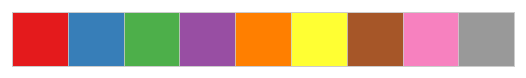

In [72]:
functions.sns.set_palette("Set1")
current_palette = functions.sns.color_palette()
functions.sns.palplot(current_palette)

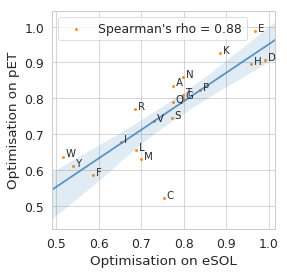

In [96]:


functions.plt.figure(figsize=(4, 4))
y = 'Optimisation on eSOL'
x = 'Optimisation on pET'
g = functions.sns.regplot('Optimisation on eSOL', 'Optimisation on pET', data=weights_df, \
                          label="Spearman's rho = 0.88", \
                         scatter_kws={'s':4, "color": current_palette[4] }, \
                          line_kws={"color": current_palette[1], 'alpha':0.8})
g.legend(loc="best")
for i, v in enumerate(weights_df['Amino acids']):
    g.annotate(' ' +v, [weights_df[y][i], weights_df[x][i]])
functions.plt.savefig('figs/weights_comparision_from_eSOL_and_pET.pdf', bbox_inches = 'tight', pad_inches = 0)

In [65]:
weights_df

,Amino acids,Optimisation on eSOL,Optimisation on pET
0,A,0.775313,0.835647
1,C,0.752677,0.520809
2,E,0.968557,0.987699
3,D,0.991984,0.907904
4,G,0.798711,0.799717
5,F,0.586659,0.584979
6,I,0.652504,0.678412
7,H,0.959811,0.894791
8,K,0.886268,0.926710
9,M,0.699244,0.629662


#### AUC on pET based on weights derived from eSOL

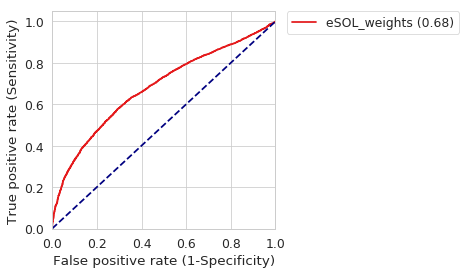

In [94]:

pET = pd.read_pickle('results/pET_complete.pkl.gz')

pET['f'] = pET['Protein'].apply(lambda x:functions.solubility_score(x, weights_from_eSOL_optimisation))
pET['eSOL_weights'] = pET['f'].apply(lambda x:np.mean(x))


roc_df = pET[['eSOL_weights']].copy()
labels = pET.Solubility.values
functions.make_roc(df=roc_df, labels=labels )
